# Lab 8: Sentiment Analysis Using Keras (CPU) Using LSTM 
# Text Analytics, Prof Evan Katsamakas, Gabelli School of Business
# TAs: Letao Li and Yukun Liu
# Version 04.08.20

Within this lab, we would like to demonstrate advanced techniques for sentiment analysis. First, we will implement Keras and tensorflow, Long short-term memory (LSTM)

What is Keras? Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.
reference:https://keras.io/

Keras contains numerous implementations of commonly used neural-network building blocks such as layers, objectives, activation functions, optimizers, and a host of tools to make working with image and text data easier to simplify the coding necessary for writing deep neural network code.

In [3]:
#Install the packages 
#pip install tensorflow==2.0.0 #in order to process Keras on CPU, use tensorflow 2.0.0 for GPU use tensorflow 2.1.0
#pip install Keras
#pip install --upgrade pip #just in case, there are warning to update the pip to the latest version

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns #for visualization

We will use dataset of IMDB reviews from Kaggle dataset. 
Reference:https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [4]:
#load the data
df = pd.read_csv('IMDB dataset.csv')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
#Clean text
import nltk 
import re
from nltk.corpus import stopwords
def preprocessing_text(review):
    my_stopwords = stopwords.words('english')
    wnl = nltk.WordNetLemmatizer()
    tag_remove = re.compile(r'<[^>]+>')
    review = tag_remove.sub('', review)
    tokens = nltk.word_tokenize(review)
    words =  [w.lower() for w in tokens if w.isalpha() if w.lower() not in my_stopwords]
    stem = [wnl.lemmatize(w) for w in words]
    clean_text = ' '.join(w for w in stem)
    return clean_text

In [7]:
df['review'] = df['review'].apply(lambda x:preprocessing_text(x))
df.head(5)

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive


In order to speed up the process, we will process a sample from the Dataset (Because we are running keras based on CPU)

In [8]:
#select a sample from dataset 
df_new = df.sample(n=10000)
df_new.head(5)

,review,sentiment
49,average surprisingly tame fulci giallo mean st...,negative
37988,enjoyed joyce complex novel keenly prepared di...,positive
23109,like hack think lone ranger reincarnated cab d...,positive
16357,rated film average screenplay direction produc...,positive
35427,really love movie real feel believe never popu...,positive


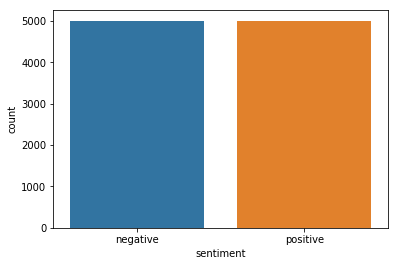

In [9]:
#sentiment base rate
sns.countplot(x='sentiment', data = df_new)

### Keras Model
There are two main types of models available in Keras: the Sequential model, and the Model class used with the functional API.
- model.layers is a flattened list of the layers comprising the model.
- model.inputs is the list of input tensors of the model.
- model.outputs is the list of output tensors of the model.
- model.summary() prints a summary representation of your model. For layers with multiple outputs, multiple is displayed instead of each individual output shape due to size limitations. Shortcut for utils.print_summary
- model.get_config() returns a dictionary containing the configuration of the model. The model can be reinstantiated from its config via:

#### 1. Keras text processing

In [10]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

#### 1.1 tokenizer, convert to sequence

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector 

pad_sequence will allow us to tranfer the text into same desire length vectors by fill "0" into or truncate respectively. 

In [11]:
tokenizer = Tokenizer(nb_words = 2500) #set the top 2500 frequent words within our observagtions as integer-index
#The word_to_index will return to a dictionary with words as keys and index as values
#This could help us to fit the model more efficiently
tokenizer.fit_on_texts(df_new['review'].values) #fit the tokenizer
sequence = tokenizer.texts_to_sequences(df_new['review'].values) #text to sequence

C:\Users\katsamakas\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [12]:
#Take a look at index word index and length
print(len(tokenizer.word_index))
print(tokenizer.word_index)

45018
{'movie': 1, 'film': 2, 'one': 3, 'like': 4, 'time': 5, 'good': 6, 'character': 7, 'would': 8, 'story': 9, 'get': 10, 'even': 11, 'make': 12, 'see': 13, 'really': 14, 'scene': 15, 'much': 16, 'well': 17, 'could': 18, 'people': 19, 'bad': 20, 'great': 21, 'also': 22, 'first': 23, 'show': 24, 'way': 25, 'thing': 26, 'made': 27, 'think': 28, 'go': 29, 'life': 30, 'know': 31, 'seen': 32, 'watch': 33, 'never': 34, 'say': 35, 'end': 36, 'many': 37, 'love': 38, 'acting': 39, 'look': 40, 'two': 41, 'plot': 42, 'actor': 43, 'little': 44, 'best': 45, 'year': 46, 'ever': 47, 'better': 48, 'man': 49, 'work': 50, 'still': 51, 'come': 52, 'take': 53, 'find': 54, 'give': 55, 'want': 56, 'part': 57, 'something': 58, 'director': 59, 'lot': 60, 'back': 61, 'watching': 62, 'guy': 63, 'real': 64, 'play': 65, 'performance': 66, 'another': 67, 'woman': 68, 'though': 69, 'funny': 70, 'nothing': 71, 'going': 72, 'actually': 73, 'role': 74, 'new': 75, 'point': 76, 'every': 77, 'old': 78, 'girl': 79, 'fac

704


C:\Users\katsamakas\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


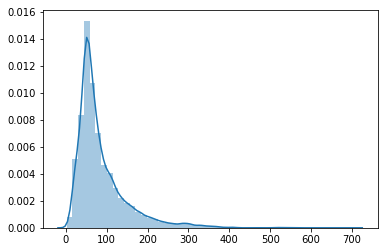

In [13]:
#set up the maximum length of review
max_length = max([len(s) for s in sequence])
print(max_length)
#if we set our desir length as max length, there will be a lot of "0", which could affect the model
#take a look at the distribution of length
df_new['seq_length'] = [len(s) for s in sequence]
sns.distplot(df_new['seq_length'].values)

In [14]:
#As we can see the above distribution, we will decide the length = mean
mean_length = int(df_new['seq_length'].mean())
mean_length

85

In [15]:
#convert sequence into pad_sequence
pad_sequence = pad_sequences(sequence, maxlen = mean_length, padding = 'post')
#fill with "0" at the end if shorter than max length

#### 1.2 Build the LSTM model and train

- The Long Short-Term Memory network (LSTM) is a type of recurrent neural network used in deep learning.
- The LSTM network has memory, which is capable of remembering across long sequences.

For this model, we will simply build three layer: Embedding layer, LSTM layer (Recurrent layer), and core layer (Dense)
- *Note: Dropout is easily implemented by randomly selecting nodes to be dropped-out with a given probability (e.g. 20%) each weight update cycle.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

Using TensorFlow backend.


In [17]:
batch_size = 64
embedding_dim = 100
model = Sequential()
#Embedding layer first
model.add(Embedding(2500, embedding_dim, input_length = mean_length))
#LSTM
model.add(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))
#Dense layer
model.add(Dense(1, activation = 'sigmoid'))#Note: The sigmoid activation: 1 / (1 + exp(-x)). 
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 85, 100)           250000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 292,305
Trainable params: 292,305
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
#split train and validation test
from sklearn.model_selection import train_test_split
#transfer sentiment to 1:'positive', 0:'negative'
df_new['label'] = df_new['sentiment'].apply(lambda x:1 if x == 'positive' else 0)
train_features, test_features, train_labels, test_labels = train_test_split(pad_sequence, df_new['label'].values, 
                                                                            test_size = 0.3)

In [19]:
model.fit(train_features, train_labels,
         batch_size = batch_size,
         epochs = 10,
         validation_data = (test_features, test_labels),
         verbose = 2)

Instructions for updating:
Use tf.cast instead.
Train on 7000 samples, validate on 3000 samples
Epoch 1/10
 - 21s - loss: 0.6803 - acc: 0.5566 - val_loss: 0.6226 - val_acc: 0.6237
Epoch 2/10
 - 19s - loss: 0.4559 - acc: 0.8107 - val_loss: 0.4044 - val_acc: 0.8310
Epoch 3/10
 - 18s - loss: 0.3893 - acc: 0.8574 - val_loss: 0.4314 - val_acc: 0.8270
Epoch 4/10
 - 18s - loss: 0.3323 - acc: 0.8870 - val_loss: 0.4271 - val_acc: 0.8347
Epoch 5/10
 - 18s - loss: 0.3206 - acc: 0.8890 - val_loss: 0.4536 - val_acc: 0.8390
Epoch 6/10
 - 19s - loss: 0.2853 - acc: 0.9086 - val_loss: 0.4431 - val_acc: 0.8340
Epoch 7/10
 - 19s - loss: 0.2793 - acc: 0.9040 - val_loss: 0.4401 - val_acc: 0.8313
Epoch 8/10
 - 17s - loss: 0.2623 - acc: 0.9124 - val_loss: 0.4759 - val_acc: 0.8257
Epoch 9/10
 - 20s - loss: 0.2597 - acc: 0.9154 - val_loss: 0.4621 - val_acc: 0.8350
Epoch 10/10
 - 19s - loss: 0.3047 - acc: 0.8987 - val_loss: 0.4631 - val_acc: 0.8347


In [20]:
#evaluate the model
df_new2 = df.iloc[[i for i in list(df.index) if i not in list(df_new.index)]]
df_new2

,review,sentiment
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
5,probably favorite movie story selflessness sac...,positive
6,sure would like see resurrection dated seahunt...,positive
7,show amazing fresh innovative idea first aired...,negative
8,encouraged positive comment film looking forwa...,negative
10,phil alien one quirky film humour based around...,negative
11,saw movie came recall scariest scene big bird ...,negative
13,cast played appreciate trying bring shakespear...,negative
14,fantastic movie three prisoner become famous o...,positive


In [21]:
df_test = df_new2.sample(n = 10000)
sequence_test = tokenizer.texts_to_sequences(df_test['review'].values)
pad_sequence_test = pad_sequences(sequence_test, maxlen = mean_length, padding = 'post')

In [22]:
df_test['labels'] = df_test['sentiment'].apply(lambda x:1 if x=='positive' else 0)

In [23]:
score, accuracy = model.evaluate(pad_sequence_test, df_test['labels'].values, batch_size = batch_size)
print(accuracy)

10000/10000 [==============================] - 6s 563us/step
0.8215


For more information is avaliable at: https://keras.io/layers/recurrent/